In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 1 - Load relevant data

In [60]:
# Import songs dataset and remove useless cols
# Split on index == 299 i.e 'Hey Mama' -> split fideles
songs = pd.read_csv('songs.csv') \
    .drop(columns=['index', 'acous', 'spch', 'pop']) \
    .iloc[299:, :] \
    .reset_index(drop=True) \
    .rename({'top genre': 'genre'}, axis=1)

# Import lyrics dataset
# (removed {}, removed all (, replaced all ): for a comma, changed file type to .csv)
lyrics = pd.read_csv(
        "fideles.csv",
        sep=",",
        quotechar='"',
        skipinitialspace=True
    ) \
    .drop(columns=['lyrics']) \
    .reset_index() \
    .rename(
        {
            'index':'title1',
            'title':'artist1',
            'artist':'lyrics'
        }, axis=1
    )

lyrics = lyrics.rename({'title1': 'title', 'artist1':'artist'}, axis=1)

# Add lyrics column
songs['lyrics'] = lyrics['lyrics']


## 2 - Songs dataset EDA

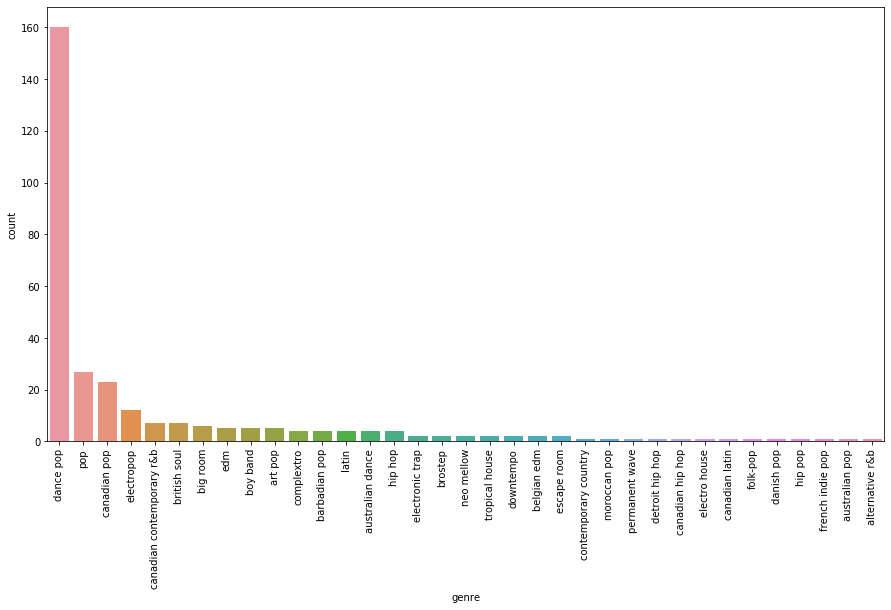

In [61]:
# Group songs by genre and absolute frequency
genres = pd.DataFrame(songs['genre'].value_counts()).reset_index().rename({'genre': 'count', 'index':'genre'}, axis=1)
fig = plt.figure(figsize = (15,8))
ax = sns.barplot(x=genres['genre'], y=genres['count'])
labels = plt.xticks(rotation=90)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86]),
 <a list of 87 Text xticklabel objects>)

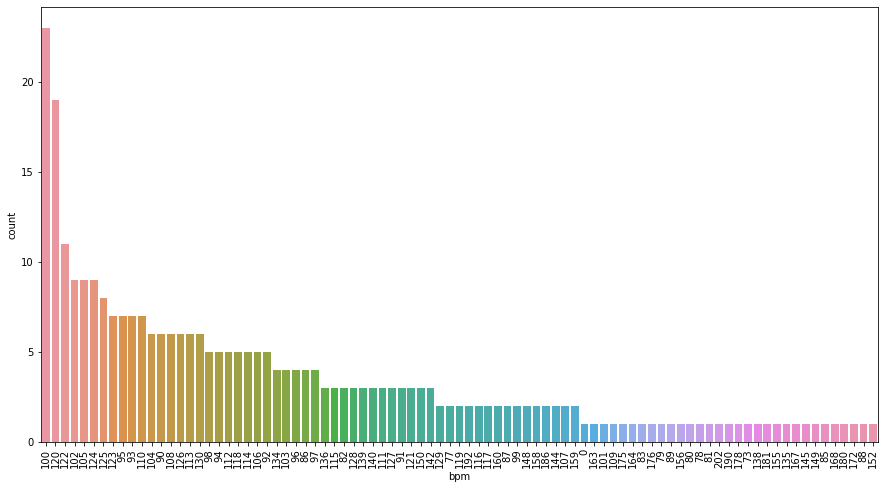

In [62]:
# Group songs by bpms and absolute frequency
bpms = pd.DataFrame(songs['bpm'].value_counts(sort=True)).reset_index().rename({'index':'bpm1', 'bpm':'count'}, axis=1)
bpms = bpms.rename({'bpm1': 'bpm'}, axis=1).sort_values(by='count', ascending=False)
fig = plt.figure(figsize = (15,8))
ax = sns.barplot(x=bpms['bpm'], y=bpms['count'], order=bpms['bpm'])
plt.xticks(rotation=90)

In [63]:
# There's one song with useless values, so we will remove it
songs.loc[songs['bpm'] == 0]


,title,artist,genre,year,bpm,nrgy,dnce,dB,live,val,dur,lyrics
143,Million Years Ago,Adele,british soul,2016,0,0,0,-60,0,0,227,"I only wanted to have fun Learning to fly, lea..."


In [64]:
def plotByYear(df, years, x, y):
    fig = plt.figure(figsize=(15, 8))
    fig.subplots_adjust(hspace=1.5, wspace=0.2)
    for year in years:
        to_plot = df.loc[year].reset_index()
        sns.barplot(x=to_plot[x], y=to_plot[y], ax=fig.add_subplot(2, 3, years.index(year) + 1))
        plt.xticks(rotation=90)
        plt.title(str(year))
    plt.show()


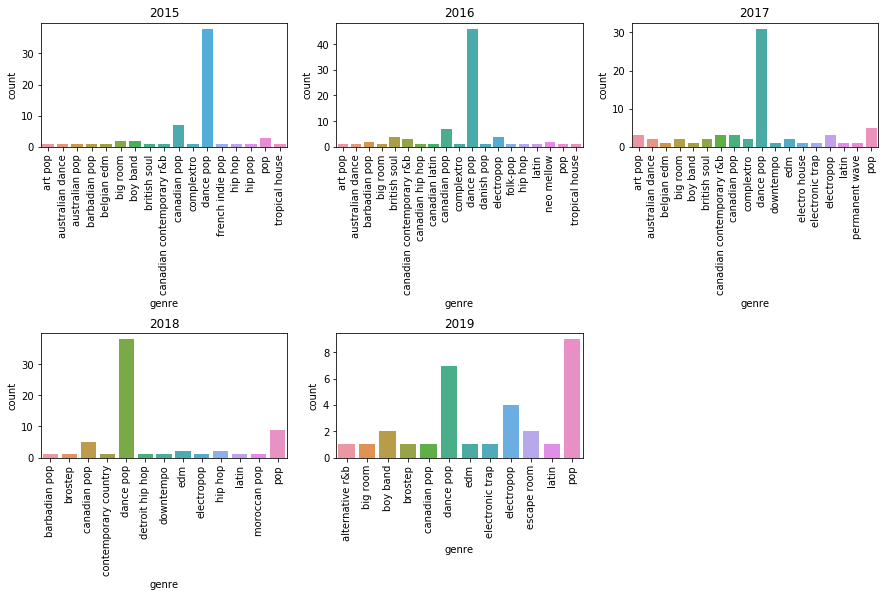

In [65]:
# Yearly analysis
groups = songs.groupby(['year', 'genre'])
yearly_genre_count = groups.count()[['title']].rename({'title': 'count'}, axis=1)

plotByYear(yearly_genre_count, [2015, 2016, 2017, 2018, 2019], 'genre', 'count')

## 2 - Cleaning lyrics dataset

In [66]:
# 1 - Remove content between []
from re import sub
lyrics['lyrics'] = lyrics.apply(
    lambda row: sub(r'\[.*?\]', '', row['lyrics']),
    axis=1
)


In [67]:
# 2 - Remove all punctuation from lyrics except single quotes ('')
# and lowercase all words
import string

lyrics['lyrics'] = lyrics.apply(
    lambda row: row['lyrics'].translate(
        str.maketrans('', '', string.punctuation.replace("'", ""))
        ).lower(),
    axis=1
)

In [68]:
# 3 - Tokenize
from nltk.tokenize import wordpunct_tokenize

lyrics['tokenized_lyrics'] = lyrics.apply(
    lambda row: wordpunct_tokenize(row['lyrics']), axis=1
)

In [69]:
# 4 - Apply POS-tagging
from nltk.tag import pos_tag

lyrics['tagged_lyrics'] = lyrics.apply(
    lambda row: pos_tag(row['tokenized_lyrics'], tagset='universal'), axis=1
)

In [82]:
# 5 - Lemmatize -> transform plurals to singular
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()

lyrics['lemmatized_lyrics'] = lyrics.apply(
    lambda row: [
        lem.lemmatize(word)
        for word in row['tokenized_lyrics']
    ],
    axis=1
)


## 2.1 Analyze tag distribution

In [70]:
from nltk import FreqDist

# 1 - Get tag frequency distribution for each song
tag_fd = pd.DataFrame(lyrics.apply(
    lambda row: dict(FreqDist(tag for (_, tag) in row['tagged_lyrics'])), axis=1
)).rename({0: 'fd'}, axis=1)

tagset, counts = [
    'ADJ', 'ADP', 'ADV',
    'CONJ', 'DET', 'NOUN',
    'NUM', 'PRT', 'PRON',
    'VERB', '.', 'X'
], []

# Get total tag distribution for all songs
for tag in tagset:
    tagcount = 0
    for i in range(len(tag_fd)):
        tagcount += tag_fd.iloc[i]['fd'].get(tag, 0)
    counts += [tagcount]


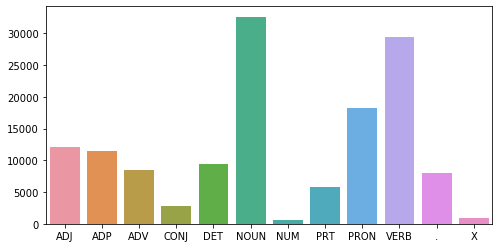

In [76]:
# Plot tag frequency distribution
fig = plt.figure(figsize = (8,4))
ax = sns.barplot(x=tagset, y=counts)

# @TODO - perguntar ao Jb se ficamos só com a classe NOUN. Frequencia > 30k para 300 músicas